# Model selection and parameter tuning

## Prepare notebook

Import libraries and functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import sys
import os
sys.path.append('../src/features')
from build_features import get_dummies
sys.path.append('../src/models')
from predict_model import clint_scorer, trump_scorer, avg_scorer
#warnings.filterwarnings("ignore")

In [2]:
random.seed(10)

Load predictors and target variable

In [3]:
# with open('../data/processed/predictors.pickle', 'rb') as file:
#     X = pickle.load(file)
with open('../data/processed/target.pickle', 'rb') as file:
    y = pickle.load(file)

Load predictors without dummies 

In [4]:
with open('../data/processed/predictors_not_dummies.pickle', 'rb') as file:
     X_no = pickle.load(file)

## Split data into train and test sets

Split the 23 (no dummies) predictors into train and test set 

In [5]:
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X_no, y)

## Define function to score model performance 

Create a metric to pass to cross_val_score when evaluating models

In [6]:
clinton_metric = make_scorer(clint_scorer)
trump_metric = make_scorer(trump_scorer)
comb_metric = make_scorer(avg_scorer)

## Define models 

Logistic regression

In [7]:
lr = LogisticRegression(
    C=2, penalty='l2', solver='lbfgs', multi_class='auto', max_iter=1000)

Random forest classifier

In [8]:
rf = RandomForestClassifier(n_estimators=100)

K-nearest neighbors

In [9]:
knn = KNeighborsClassifier()

Support vector machine

In [10]:
svm = SVC(kernel='linear')

##  Evaluate training performance

Create a list of model names and model variables 

In [11]:
name_list = ['Logistic regression', 'Random forest', 'K-nearest neighbors', 'Support vector machine']
model_list = [lr, rf, knn, svm]

Cross validate all of the models and print scores and score mean for each for  Clinton 

In [12]:
for idx, model in enumerate(model_list): 
    clint_scores = cross_val_score(
    model, X_train_rfe, y_train_rfe, cv=5, scoring=clinton_metric, n_jobs=-1)
    name = name_list[idx]
    print(name,":", clint_scores, round(clint_scores.mean(), 5))

Logistic regression : [91.  88.4 90.1 92.1 88.9] 90.1
Random forest : [89.9 89.5 91.2 91.  88. ] 89.92
K-nearest neighbors : [87.8 86.3 89.9 88.6 83.9] 87.3
Support vector machine : [91.2 89.  90.8 92.7 88.7] 90.48


Cross validate all of the models and print scores and score mean for each for Trump

In [13]:
for idx, model in enumerate(model_list): 
    trump_scores = cross_val_score(
    model, X_train_rfe, y_train_rfe, cv=5, scoring=trump_metric, n_jobs=-1)
    name = name_list[idx]
    print(name, ":", trump_scores, 'Mean:', round(trump_scores.mean(), 5))

Logistic regression : [87.1 85.8 86.2 85.6 87.7] Mean: 86.48
Random forest : [90.6 88.3 89.6 88.7 89. ] Mean: 89.24
K-nearest neighbors : [85.4 83.7 85.4 84.6 84.2] Mean: 84.66
Support vector machine : [87.3 85.4 86.2 85.4 86.2] Mean: 86.1


Cross validate and evaluate using the combined Trump/Clinton metric on non-dummy predictors 

In [14]:
for idx, model in enumerate(model_list): 
    comb_scores = cross_val_score(
    model, X_train_rfe, y_train_rfe, cv=5, scoring=comb_metric, n_jobs=-1)
    name = name_list[idx]
    print(name, comb_scores, comb_scores.mean())

Logistic regression [89.05 87.1  88.15 88.85 88.3 ] 88.28999999999999
Random forest [90.05 88.35 89.85 89.1  88.7 ] 89.21000000000001
K-nearest neighbors [86.6  85.   87.65 86.6  84.05] 85.98
Support vector machine [89.25 87.2  88.5  89.05 87.45] 88.28999999999999


Use recursive feature elimination on non-dummy variables on two top performing models (LR and RF)

In [15]:
selector_lr = RFECV(lr, step=1, min_features_to_select=1,  scoring=comb_metric, cv=5)
selector_lr.fit(X_train_rfe, y_train_rfe)

RFECV(cv=5,
      estimator=LogisticRegression(C=2, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=1000,
                                   multi_class='auto', n_jobs=None,
                                   penalty='l2', random_state=None,
                                   solver='lbfgs', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring=make_scorer(avg_scorer),
      step=1, verbose=0)

In [16]:
selector_rf = RFECV(rf, step=1, min_features_to_select=1,  
                    scoring=comb_metric, cv=5)
selector_rf.fit(X_train_rfe, y_train_rfe)

RFECV(cv=5,
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring=make_scorer(avg_scorer),
      step=1, verbose=0)

Print findings from RFE 

In [17]:
print(selector_lr.ranking_)
rank_list = selector_lr.ranking_
feature_ranks = []
no = []
yes = []
for idx, rank in enumerate(rank_list):
    feature_ranks.append([rank, X_train_rfe.columns[idx]])
for list in feature_ranks:
    if list[0] != 1:
        #print('no', list)
        no.append(list)
    if list[0] == 1:
        #print('yes', list)
        yes.append(list)
#print(no)
print(yes) # immigration, terrorism, climate change, the budget deficit, racial equality, 

[ 5 11  1  1  7  1  1 14  2 15 13  1 12  9  8  1  6  3  4 10  1  1  1]
[[1, 'imiss_c_2016'], [1, 'imiss_d_2016'], [1, 'imiss_f_2016'], [1, 'imiss_g_2016'], [1, 'imiss_l_2016'], [1, 'imiss_p_2016'], [1, 'imiss_u_2016'], [1, 'imiss_x_2016'], [1, 'imiss_y_2016']]


Selected feature count using non-dummies

In [19]:
print('Optimal number of features: {}'.format(selector_lr.n_features_))
print('Optimal number of features: {}'.format(selector_rf.n_features_))

Optimal number of features: 9
Optimal number of features: 22


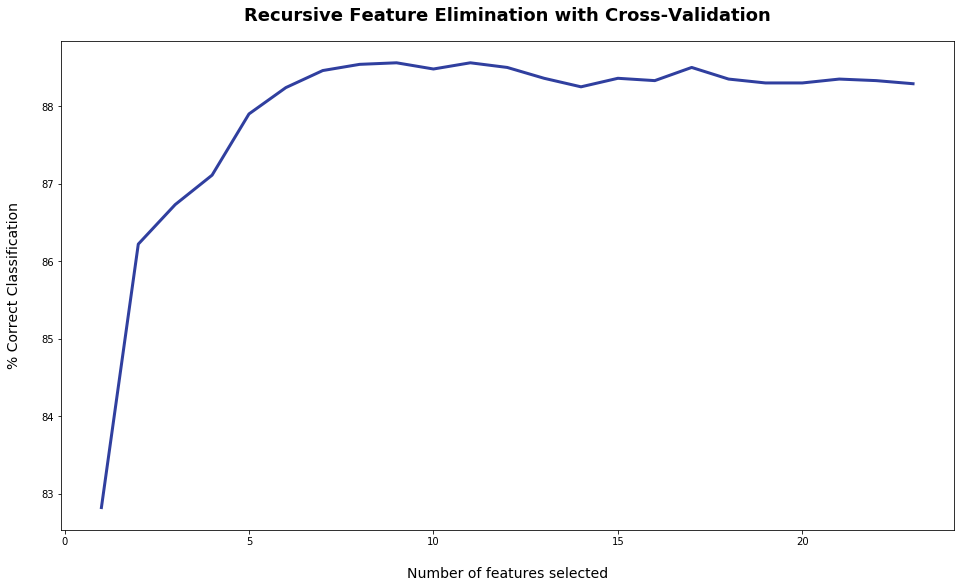

In [20]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(selector_lr.grid_scores_) + 1), selector_lr.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

Drop unneeded attributes

In [21]:
print(np.where(selector_lr.support_ == False)[0])

X_dropped = X_no.drop(X_no.columns[np.where(selector_lr.support_ == False)[0]], axis=1)

[ 0  1  4  7  8  9 10 12 13 14 16 17 18 19]


In [22]:
print(len(X_dropped.columns))
X_dropped.head()

9


,imiss_c_2016,imiss_d_2016,imiss_f_2016,imiss_g_2016,imiss_l_2016,imiss_p_2016,imiss_u_2016,imiss_x_2016,imiss_y_2016
0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0
1,2.0,2.0,1.0,4.0,4.0,1.0,2.0,3.0,4.0
2,2.0,1.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0
3,3.0,1.0,2.0,3.0,2.0,3.0,2.0,2.0,3.0
4,1.0,1.0,1.0,3.0,4.0,1.0,1.0,1.0,1.0


Get dummies for X with fewer attributes

In [23]:
X = get_dummies(X_dropped)

Number of columns in new X 

In [24]:
len(X.columns)

36

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

Show rfe feature importances

## Parameter tuning

Define parameter grid for random forest

In [26]:
param_grid = {'n_estimators': [100], 'max_depth': [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'oob_score': [True], 'max_features': [None, 'sqrt']}

Find the best parameters and then crossvalidate with five folds

In [27]:
grid = GridSearchCV(rf, param_grid, iid=True, cv=5, n_jobs=-1,
                    scoring=comb_metric, verbose=1, return_train_score=True)

Fit training data to grid

In [28]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.6s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid=Tr

Print best parameters and best score

In [29]:
print(grid.best_params_)
print(round(grid.best_score_, 3))

{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100, 'oob_score': True}
88.73


## Evaluate test performance

In [30]:
scores_rf = cross_validate(grid, X_test, y_test, scoring=comb_metric, cv=5)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.5s finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.8s finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.1s finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.4s finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.0s finished


In [31]:
scores_rf['test_score'].mean()

88.10999999999999

In [32]:
scores_lr = cross_validate(lr, X_test, y_test, scoring=comb_metric, cv=5)
scores_lr['test_score'].mean()

89.53

In [34]:
scores_svm = cross_validate(svm, X_test, y_test, scoring=comb_metric, cv=5)
scores_svm['test_score'].mean()

89.46000000000001